# Desafío 5

La idea es que entrenen un modelo de clasificación de sentiment analysis para un dataset de reviews de apps utilizando BERT como encoder.

 Intenten hacer un primer entrenamiento con el código que ya está, como para comprobar que lo pueden ejecutar y que lo entienden. Lleguen sólo hasta la parte que dice "3-BERT Fine tuning".

 Reporten el F1-score en un conjunto de datos de prueba.

 Entrenar un modelo con las 5 clases originales.

 Intenten agregar una capa densa previa a la de salida.

# Código Preliminar
_Código extraido de la notebook de clase para pre-procesar el dataset y demás._

In [1]:
!pip install transformers --quiet
import tensorflow
from transformers import TFBertModel

import pandas as pd
import numpy as np


import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")
plt.style.use('dark_background')
def plot_train_metrics(history):
    epoch_count = range(1, len(history.history['accuracy']) + 1)
    sns.lineplot(x=epoch_count,  y=history.history['accuracy'], label='train')
    sns.lineplot(x=epoch_count,  y=history.history['val_accuracy'], label='valid')
    plt.show()



[notice] A new release of pip available: 22.2.1 -> 24.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


### Datos
Utilizaremos como dataset críticas de Google Apps en formato csv.

In [2]:
# Armar el dataset
df = pd.read_csv('data/d5/reviews.csv')
df.head(1)

,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,sortOrder,appId
0,Andrew Thomas,https://lh3.googleusercontent.com/a-/AOh14GiHd...,Update: After getting a response from the deve...,1,21,4.17.0.3,2020-04-05 22:25:57,"According to our TOS, and the term you have ag...",2020-04-05 15:10:24,most_relevant,com.anydo


In [3]:
print("Cantidad de críticas:", len(df))

Cantidad de críticas: 15746


<Axes: xlabel='score', ylabel='count'>

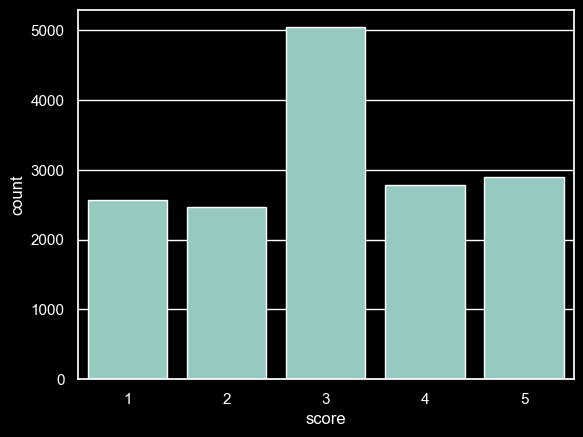

In [4]:
# ¿Cómo están balanceados los datos?
sns.countplot(x=df.score)

### Limpieza de datos

In [5]:
# Balancear los datos
df['sentiment'] = df.score
class_names = ['very negative', 'negative', 'neutral', 'positive', 'very positive']
print(df.score.values)

[1 1 1 ... 5 5 5]


In [6]:
sentences = df['content'].values
print("sentences shape:", sentences.shape)
sentences[:3]

sentences shape: (15746,)


array(["Update: After getting a response from the developer I would change my rating to 0 stars if possible. These guys hide behind confusing and opaque terms and refuse to budge at all. I'm so annoyed that my money has been lost to them! Really terrible customer experience. Original: Be very careful when signing up for a free trial of this app. If you happen to go over they automatically charge you for a full years subscription and refuse to refund. Terrible customer experience and the app is just OK.",
       'Used it for a fair amount of time without any problems. Suddenly then asked me to create an account or log using Google or FB. I used my Google one only to discover everything was gone!',
       "Your app sucks now!!!!! Used to be good but now doesn't update until I physically open it up and then close it then scroll and then it finally shows what I want to put on the list!!!!!! And I FRIGGEN paid for this garbage!!!!!!!"],
      dtype=object)

Median: 139.0


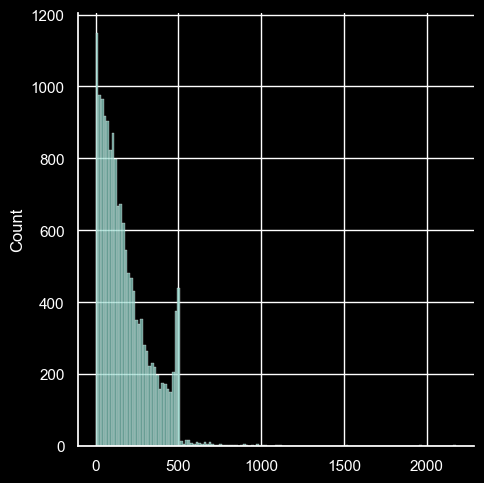

In [7]:
sentence_lens = []

for sentence in sentences:
  sentence_lens.append(len(sentence))

print("Median:", np.median(sentence_lens))
sns.displot(sentence_lens)

In [8]:
y = df['sentiment'].values - 1
print(df['sentiment'].unique())
print("y shape:", y.shape)
y = tensorflow.keras.utils.to_categorical(y)
print(y.shape)
output_shape = y.shape[1]
print("output shape:", output_shape)

[1 2 3 4 5]
y shape: (15746,)
(15746, 5)
output shape: 5


### Data generator


In [9]:
from transformers import InputExample, InputFeatures  # Métodos para transformar el dataset
from transformers import BertTokenizer
import numpy as np

# Muy importante que para tensorflow los modelos Bert deben empezar con "TF"
# de lo contrario estaremos utilizando un modelo para pytorch

# Descargamos el modelo base de BERT más liviano y su correspondiente tokenizer
bert_tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

In [10]:
# Del dataset original accederemos a los datos por índices (idx)
# mezclados aleatoriamente
from sklearn.model_selection import train_test_split
max_length = 140 # BERT soporta máximo 512
indices = np.arange(len(sentences))
idx_train_val, idx_test = train_test_split(indices, test_size=0.2, random_state=42)
idx_train, idx_val = train_test_split(idx_train_val, test_size=0.2, random_state=42)

In [11]:
def convert_data_to_examples(text, labels, idx_train, idx_val):
    # Armamos un "InputExample" para los datos de entrenamiento y validación
    train_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_train]

    validation_InputExamples = [InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = text[i],
                                                          text_b = None,
                                                          label = labels[i]) for i in idx_val]

    return train_InputExamples, validation_InputExamples


def convert_examples_to_tf_dataset(examples, bert_tokenizer, max_length=512):
    # Transformamos los datos de entrada en tensorres de:
    # input_ids --> token id
    # attention_mask
    # token type
    features = []

    for e in examples:
        # Documentation is really strong for this method, so please take a look at it
        input_dict = bert_tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=False,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, attention_mask = (input_dict["input_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, label=e.label
            )
        )

    def gen():
    # Función generadora para no levantar todos los datos en un instante
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                },
                f.label,
            )

    return tensorflow.data.Dataset.from_generator(
        # Tensorflow dataset generator (basado en el generador y en el esquema de datos definido)
        gen,
        ({"input_ids": tensorflow.int32, "attention_mask": tensorflow.int32}, tensorflow.float32),
        (
            {
                "input_ids": tensorflow.TensorShape([None]),
                "attention_mask": tensorflow.TensorShape([None]),
            },
            tensorflow.TensorShape([output_shape]),
        ),
    )

In [12]:
train_InputExamples, validation_InputExamples = convert_data_to_examples(sentences, y, idx_train, idx_val)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), bert_tokenizer, max_length=max_length)
# shuffle 100 --> mezcla los datos y los lee a de 100 unidades
# batch 32 --> ejecuta una epoca de entrenamiento de a 32 unidades
train_data = train_data.shuffle(100).batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), bert_tokenizer, max_length=max_length)
validation_data = validation_data.batch(32)

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead


In [13]:
pred_sentences = [sentences[i] for i in idx_test]
tf_batch = bert_tokenizer(pred_sentences, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

In [14]:
X_test = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [15]:
y_test = y[idx_test]

# Sentiment Classifier (BERT > Softmax)

In [16]:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
max_length = 140
output_shape = 5
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

outputs = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = outputs.pooler_output

x = tensorflow.keras.layers.Dropout(0.2)(pooled_output)
output = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(x)

model = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [17]:
history = model.fit(train_data, epochs=10, validation_data=validation_data)
model.save('models/bert_sent_classifier.keras')

Epoch 1/10


315/315 [==============================] - 1787s 6s/step - loss: 1.6139 - accuracy: 0.2934 - f1_score: 0.2248 - val_loss: 1.4983 - val_accuracy: 0.3567 - val_f1_score: 0.2353
Epoch 2/10
315/315 [==============================] - 1744s 6s/step - loss: 1.5242 - accuracy: 0.3326 - f1_score: 0.2554 - val_loss: 1.4416 - val_accuracy: 0.4067 - val_f1_score: 0.3232
Epoch 3/10
315/315 [==============================] - 1755s 6s/step - loss: 1.4779 - accuracy: 0.3551 - f1_score: 0.2872 - val_loss: 1.3984 - val_accuracy: 0.4218 - val_f1_score: 0.2764
Epoch 4/10
315/315 [==============================] - 1746s 6s/step - loss: 1.4494 - accuracy: 0.3726 - f1_score: 0.3037 - val_loss: 1.4013 - val_accuracy: 0.4040 - val_f1_score: 0.3189
Epoch 5/10
315/315 [==============================] - 1756s 6s/step - loss: 1.4240 - accuracy: 0.3903 - f1_score: 0.3205 - val_loss: 1.3644 - val_accuracy: 0.4313 - val_f1_score: 0.3355
Epoch 6/10
315/315 [==============================] - 1765s 6s/step 

c:\Python\3.10.6\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


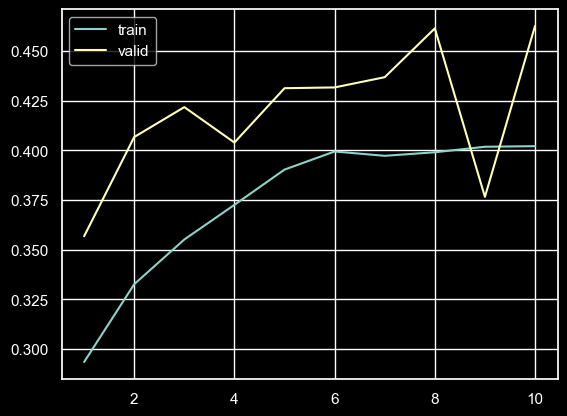

In [18]:
plot_train_metrics(history)

# Sentiment Classifier (BERT > Capas Lineales > Softmax)

In [31]:
# Replicaremos todo lo realizado anteriormente, pero adjuntaremos capas lineales entre
# el output de BERT y la capa de Softmax:
bert_model = TFBertModel.from_pretrained("bert-base-uncased")
max_length = 140
output_shape = 5
bert_model.bert.trainable = False

input_ids = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='input_ids')
attention_mask = tensorflow.keras.layers.Input(shape=(max_length,), dtype=tensorflow.int32, name='attention_mask')

bert_output = bert_model(input_ids, attention_mask=attention_mask)

pooled_output = bert_output.pooler_output

droput1 = tensorflow.keras.layers.Dropout(0.2)(pooled_output)

# Aquí reside la diferencia respecto al primer modelo: ###############
lin1 = tensorflow.keras.layers.Dense(512, activation='relu')(droput1)
lin2 = tensorflow.keras.layers.Dense(256, activation='relu')(lin1)
lin3 = tensorflow.keras.layers.Dense(128, activation='relu')(lin2)
######################################################################

softmax = tensorflow.keras.layers.Dense(output_shape, activation='softmax')(lin3)

model2 = tensorflow.keras.Model(inputs=[input_ids, attention_mask], outputs=softmax)

model2.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy',tensorflow.keras.metrics.F1Score(average='macro')])

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [32]:
# Entrenamos y guardamos el segundo modelo, tal como hicimos con el primero.
history2 = model2.fit(train_data, epochs=10, validation_data=validation_data)
model2.save('models/bert_sent_classifier2.keras')

Epoch 1/10
315/315 [==============================] - 1855s 6s/step - loss: 1.5452 - accuracy: 0.3272 - f1_score: 0.1926 - val_loss: 1.5949 - val_accuracy: 0.2909 - val_f1_score: 0.1522
Epoch 2/10
315/315 [==============================] - 1820s 6s/step - loss: 1.4389 - accuracy: 0.3695 - f1_score: 0.2400 - val_loss: 1.4254 - val_accuracy: 0.3690 - val_f1_score: 0.2408
Epoch 3/10
315/315 [==============================] - 1816s 6s/step - loss: 1.4057 - accuracy: 0.3871 - f1_score: 0.2654 - val_loss: 1.4003 - val_accuracy: 0.3889 - val_f1_score: 0.2703
Epoch 4/10
315/315 [==============================] - 1817s 6s/step - loss: 1.3859 - accuracy: 0.4005 - f1_score: 0.2885 - val_loss: 1.3440 - val_accuracy: 0.4484 - val_f1_score: 0.3043
Epoch 5/10
315/315 [==============================] - 1815s 6s/step - loss: 1.3725 - accuracy: 0.4059 - f1_score: 0.2958 - val_loss: 1.3549 - val_accuracy: 0.4226 - val_f1_score: 0.2992
Epoch 6/10
315/315 [==============================] - 1818s 6s/step - 

c:\Python\3.10.6\lib\site-packages\transformers\generation\tf_utils.py:465: UserWarning: `seed_generator` is deprecated and will be removed in a future version.
  warnings.warn("`seed_generator` is deprecated and will be removed in a future version.", UserWarning)


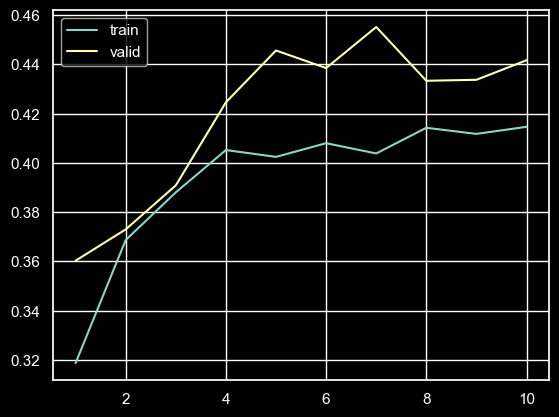

In [21]:
plot_train_metrics(history2)

In [23]:
# Calculamos la exactitud (accuracy)
scores = model2.evaluate(X_test, y_test)
scores[1]

99/99 [==============================] - 422s 4s/step - loss: 1.3038 - accuracy: 0.4241 - f1_score: 0.3139


0.4241269826889038

## Ensayo
_(Fragmento extraido del ntoebook original)._

In [ ]:
model2 = tensorflow.keras.models.load_model('models/bert_sent_classifier2.keras')

In [24]:
text = "I love this app!"

#tf_batch = bert_tokenizer(text, max_length=max_length, padding=True, truncation=True, return_tensors='tf')

tf_batch = bert_tokenizer.encode_plus(
    text,
    add_special_tokens=True,
    max_length=max_length, # truncates if len(s) > max_length
    return_token_type_ids=False,
    return_attention_mask=True,
    pad_to_max_length=True, # pads to the right by default # CHECK THIS for pad_to_max_length
    truncation=True,
    return_tensors='tf'
)

print("Inputs ids:", tf_batch['input_ids'])
print("Attention mask:", tf_batch['attention_mask'])

Inputs ids: tf.Tensor(
[[  101  1045  2293  2023 10439   999   102     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0]], shape=(1, 140), dtype=int32)
Attention mask: tf.Tensor(
[[1 1 1 1 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 

c:\Python\3.10.6\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [25]:
X_ensayo = [tf_batch['input_ids'],
          tf_batch['attention_mask']]

In [27]:
y_prob_ensayo = model2.predict(X_ensayo)
y_prob = np.argmax(y_prob_ensayo, axis=1)
print("Clasificación:", class_names[int(y_prob)])

1/1 [==============================] - 10s 10s/step
Clasificación: very positive


C:\Users\ldmus\AppData\Local\Temp\ipykernel_4488\3929104758.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print("Clasificación:", class_names[int(y_prob)])


## Conclusiones

El hecho de no hacer _binning_ en los datos (colapsando 5 clases a 3) como en el ejemplo original, disminuye el accuracy significativamente, ya que hay u nespectro más amplio de error. Esto hace que partamos de una métrica peor en el modelo más básico (el modelo de lenguaje BERT seguido simplemente de una capa de Softmax como clasificador).

En la propuesta del enunciado (adjuntar capas lineales tras el modelo de lenguaje, y previas a la de Softmax) se logra mejorar un poco el desempeño del modelo. Cabe destacar que no tiene sentido no hacer algo com oesto, ya que el tiempo de entrenamiento y predicción casi no se altera (BERT consume la mayoría de cada iteración, por lo que es su tiempo el que predomina en el tiempo total por época).

De todas formas, las métricas obtenidas están lejos de ser aceptables para entornos productivos. En ese caso, precisaremos realizar _fioe-tunning_ como en el notebook original.